The aim of this research work is to propose a Machine Learning algorithm for eigenvalue problems, particularly, the Time-independent Schrodinger equation, since it is instrumental in characterizing the behavior of physical systems and are often very challenging to solve, especially in high-dimensions. 

For this notebook, we will restrict (for simplicity) the problem to one dimension and solve a simple Eigenvalue problem defined as:

\begin{equation}
\frac{d^2  y(x)}{dx^2} = - \lambda y(x)
\end{equation}

where $\lambda$ is the eigenvalue of the problem. Given the boundary conditions: $y(0) = y(L) = 0 $

**THE EXACT SOLUTION**

The exact solution is given as
\begin{equation}
y_{n} (x) = A_{n} sin(\frac{n \pi x}{L})
\end{equation}
and
\begin{equation}
\lambda_{n} =  \left( \frac{n \pi}{L}\right)^2
\end{equation}
with

\begin{equation}
A_n = \sqrt{\frac{2}{L}}
\end{equation}

Now, we consider the problem for $L = \pi$

**In contrast to the previous notebooks, here we will obtain all eigenpairs in one training and a single shot. In later notebooks, the problem will be extended to complicated potentials $V(x)$ (here V = 0), and probably high dimensions. Also, we will consider learning the operator.**

In [2]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
from torch import Tensor
import torch.nn as nn
import torch.optim as optim     #optimizer
import time
import copy
import pandas as pd  #for the moving average

torch.manual_seed(1234)

np.random.seed(1234)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
  print(torch.cuda.get_device_name(0))

!pip install pyDOE
from pyDOE import lhs #latin hypercube sampling

cuda
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=2feafeca92cad8939ca4639bbad54c10ad665cd777fed1933e971c9cd3ac94f6
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [3]:
#The sine activation function
class sine(torch.nn.Module):
  @staticmethod
  def forward(input):
    return torch.sin(input)

#Automatic differentiation in pytorch
def dfx(f, x):
  grads = []
  for i in range(f.shape[1]):  # Loop over each column
      gouts = torch.zeros_like(f, dtype = torch.float, device = device)
      gouts[:, i] = 1.0  # Differentiate w.r.t. one column at a time
      df_i = grad([f], [x], grad_outputs=gouts, create_graph=True)[0]
      grads.append(df_i)  # Collect gradients for each column

  return torch.stack(grads, dim=-1)

In [4]:
#Defining the hyperparameters
t0 =0; tf = torch.pi; xbc = 0; eig_num = 6
col_pts = 201 ; layers = [1,100,100,eig_num]; lr = 1e-2; epochs =10000

In [5]:
#Defining the Parametric Solution
#This enforces the solution on the boundaries
def parametricSolutions(t,nn,t0,tf, bound):
  N1 = nn(t)
  f = ((1-torch.exp(-(t - t0)))*(1-torch.exp(t - tf))).view(-1,1)
  psi_hat = bound + f*N1 #Broadcasting is done here
  return psi_hat

In [6]:
def hamEqs_Loss(t,psi): #Defines the PDE loss
  psi_x = dfx(psi,t).squeeze(1)
  psi_xx = dfx(psi_x,t).squeeze(1)
  E  = torch.sum(psi * (-psi_xx), dim=0)/torch.sum(psi * psi, dim=0) #The eigenvalues
  L = (psi_xx) + (E)*psi
  return L,E

In [7]:
#Defining the Frobenius norm
def frobenius_norm(G):
    I = torch.eye(G.shape[0], device = device, dtype = G.dtype)
    loss = torch.linalg.matrix_norm(G - I) #The frobenius norm
    return loss

#Defining the monotonicity_penalty, this is to ensure that the eigenpairs are learned monotonically
def monotonicity_penalty(E, margin = 0.0):
    diffs = E[:-1] - E[1:] + margin
    penalty = torch.relu(diffs).sum()
    return penalty

#Defining the cosine matrix
def cosine_matrix(psi):
    psi_norm = psi / torch.norm(psi, dim = 0, keepdim = True)
    cos_matrix = psi_norm.T @ psi_norm
    return cos_matrix

In [8]:
#Defining the NN architecture without symmetry
class qNN(torch.nn.Module):
  def __init__(self,layers):
    super(qNN,self).__init__()
    self.activation = sine()

    #Defining the Layers
    self.linears = torch.nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])

    #Initializing the weights
    #self.apply(weights_init)
    for i in range(len(layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      nn.init.zeros_(self.linears[i].bias.data)


  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a = x.float()
    #In1 = self.ein(torch.ones_like(a))
    for i in range(len(self.linears)-1):
      z = self.linears[i](a)
      #z = self.batch_norms[i](z)
      a = self.activation(z)

    a = self.linears[-1](a)
    return a

In [9]:
model = qNN(layers)
model.to(device)
print(model)
#params = list(model.parameters())
betas = [0.999, 0.9999]
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas)

qNN(
  (activation): sine()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=6, bias=True)
  )
)


In [10]:
def nn_train(NN,t0,tf,xbc,col_pts, epochs,t):
  En_history = [] #To store the eigenvalues as it is optimized
  loss_keys = ['pde_loss_hist','gram_loss_hist','total_loss_hist']
  loss_dic = {key: [] for key in loss_keys} #To store the losses
  t_rand = t[torch.randperm(t.shape[0])].to(device).float() #Reshuffling the collocation points
  t_rand.requires_grad =True

  #Dictionary to store the final training
  dic = {}

  stime = time.time()
  for iter in range(epochs + 1):
    loss = 0.0

    #Getting the parametric solution
    psi =parametricSolutions(t_rand,NN,t0,tf,xbc).to(device) #The forward pass

    L,En = hamEqs_Loss(t_rand,psi)
    En_history.append(En.cpu().detach().numpy())
    Loss = torch.nn.MSELoss()
    criteria_loss = eig_num*Loss(L,torch.zeros_like(L)) #The scaled pde_loss
    #Getting the loss after the forward pass
    loss_dic['pde_loss_hist'].append(criteria_loss.cpu().detach().numpy().item())

    #The attention or Grams Matrix (actually the cosine matrix)
    G = cosine_matrix(psi)
    lossG = 1000*frobenius_norm(G)
    loss_dic['gram_loss_hist'].append(lossG.cpu().detach().numpy().item())

    #The eigenvalue loss
    #loss_eig = monotonicity_penalty(En, 0.1)

    total_loss = criteria_loss + lossG #+ loss_eig



    if iter % 500 == 0:
      print('--------------------------------------------')
      print(f'Epoch: {iter}')
      print(f'En: {En_history[-1]}')
      print('--------------------------------------------')
      print('Total_loss: ',total_loss.cpu().detach().numpy())


    #Backward propagation
    optimizer.zero_grad()
    total_loss.backward()
    #Introducing Gradient clipping
    #max_norm =12.0
    #torch.nn.utils.clip_grad_norm_(NN.parameters(), max_norm)
    optimizer.step()
    loss += total_loss.cpu().detach().numpy()


    #Storing the loss after each iteration
    loss_dic['total_loss_hist'].append(loss)


  #Storing the final eigenfunction and eigenvalue
  dic[1] = copy.deepcopy(NN)


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return loss_dic, np.array(En_history), dic

In [11]:
x_lhs = torch.tensor(0 + (np.pi - 0)*lhs(1,col_pts))
x_lhs.shape

torch.Size([201, 1])

In [12]:
Loss, eig_vals, qPINN = nn_train(model,t0,tf,xbc,col_pts,epochs, x_lhs)    

--------------------------------------------
Epoch: 0
En: [1.1929895 1.3945624 1.5568609 1.2786372 1.4432205 1.4154571]
--------------------------------------------
Total_loss:  5454.6123
--------------------------------------------
Epoch: 500
En: [ 5.0006304  2.5087578 16.204414  25.909298   8.404242   1.4753352]
--------------------------------------------
Total_loss:  1412.371
--------------------------------------------
Epoch: 1000
En: [ 3.8345392  4.083591  15.932194  25.35475    9.0023     1.1201637]
--------------------------------------------
Total_loss:  1274.9026
--------------------------------------------
Epoch: 1500
En: [ 3.5706842  4.270816  15.960248  24.906878   9.191994   1.5495213]
--------------------------------------------
Total_loss:  1220.6075
--------------------------------------------
Epoch: 2000
En: [ 3.3300886  1.8706256 15.976011  24.824905   9.047214  39.144142 ]
--------------------------------------------
Total_loss:  390.0442
---------------------------

In [17]:
tTest = torch.linspace(0,np.pi,1200).view(-1,1)
tTest.requires_grad=True
t_net = tTest.detach().numpy()

psi = parametricSolutions(tTest,qPINN[1].cpu(),t0,tf,xbc).data.numpy()

In [36]:
#Sorting the eigenfunctions
eigs = eig_vals[-1]
indices = np.argsort(eigs)
eigs_arranged = eigs[indices]

psi = psi[:,indices]

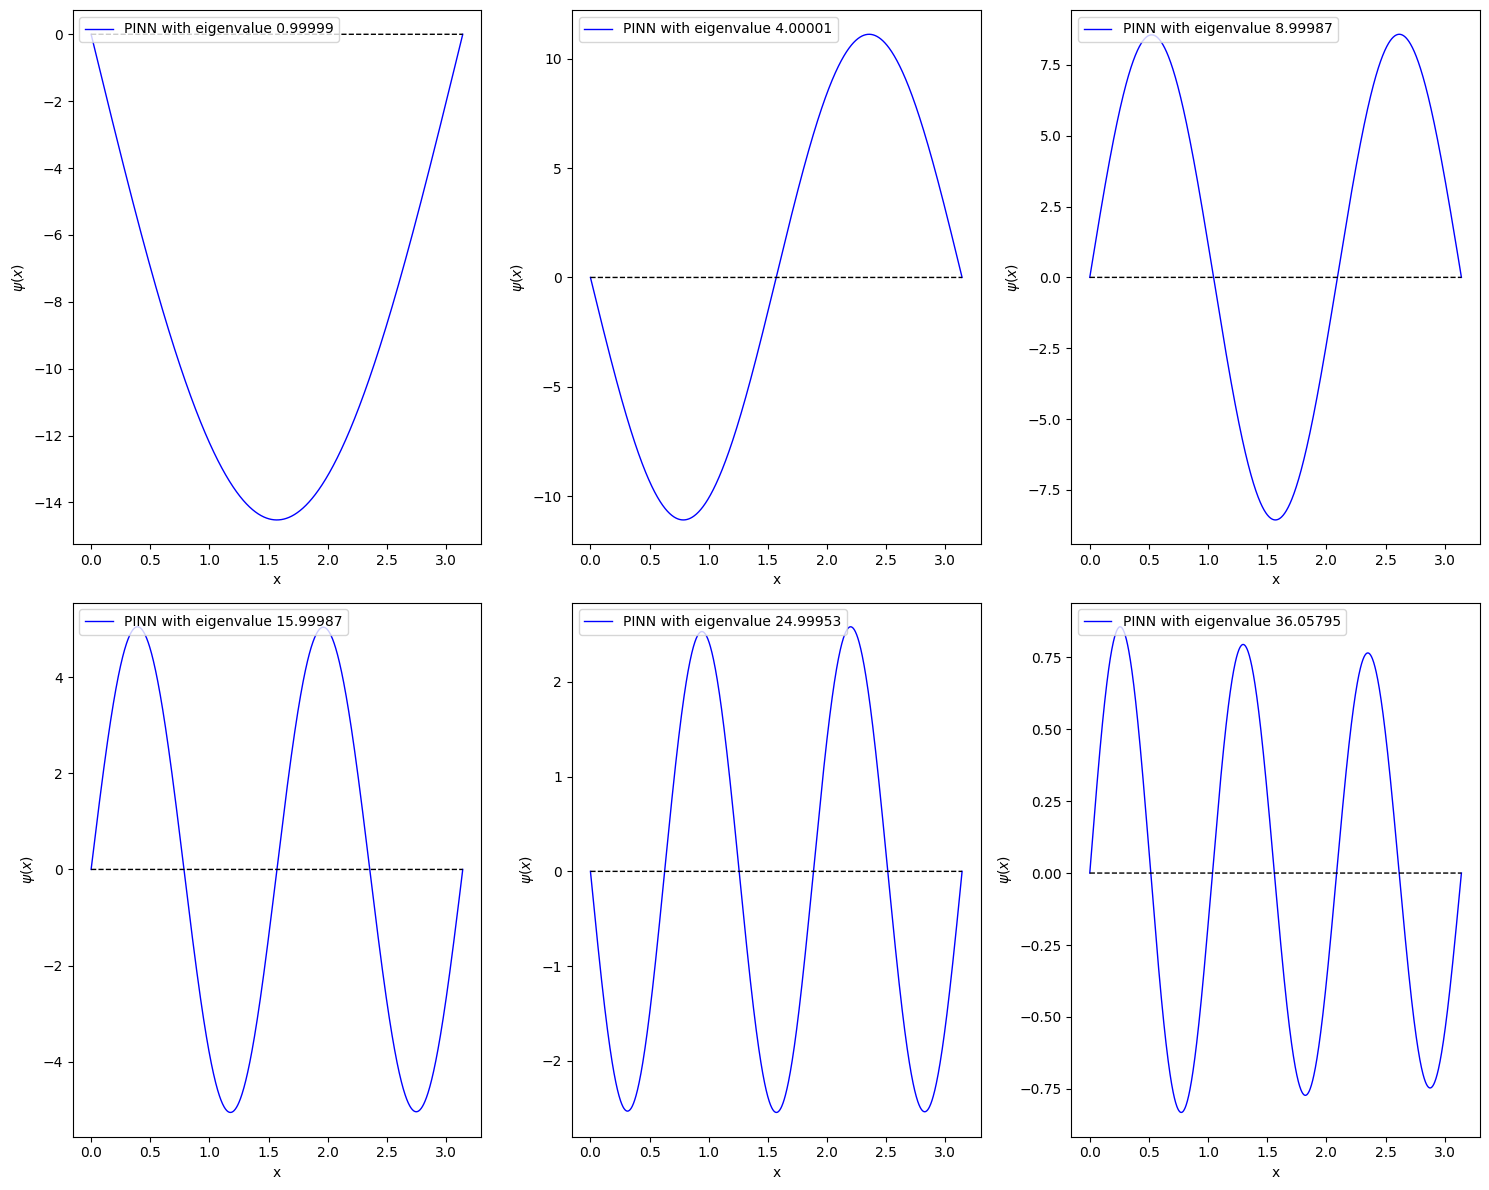

In [70]:
#Defining the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Calculating the total number of subplots needed
total_subplots = eig_vals[-1].shape[0]

# Creating a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# Iterating over eigenvalues and corresponding solutions
for index, eig in enumerate(eigs_arranged[:total_subplots]):
    row_index = index // num_cols  # row index
    col_index = index % num_cols   # column index

    # Plot on the corresponding subplot
    #psi_i = psi[index] + En_counter[index]
    ax = axes[row_index, col_index]
    ax.plot(t_net, psi[:,index], color='blue', linewidth=1, label=f'PINN with eigenvalue {eigs_arranged[index]:.5f}')
    ax.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
    ax.set_xlabel('x', color='black')
    ax.set_ylabel('$\psi(x)$', color='black')
    ax.tick_params(axis='y', color='black')
    ax.legend(loc = 'upper left')

# Hiding the unused subplot
if total_subplots < num_rows * num_cols:
    for i in range(total_subplots, num_rows * num_cols):
        fig.delaxes(axes.flat[i])
# Adjusting layout to prevent overlap
plt.tight_layout()

plt.show()

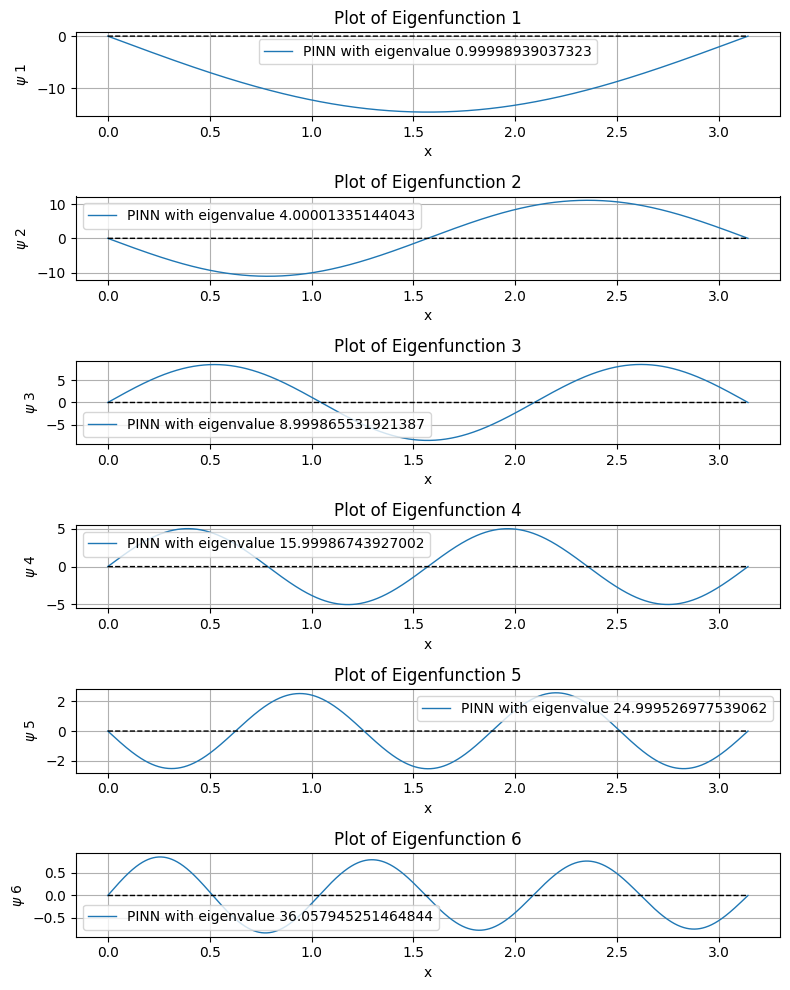

In [71]:

fig, axes = plt.subplots(eig_num, 1, figsize=(8, 10))  # 3 rows, 1 column


# Plot each column in a separate subplot
for i in range(eig_num):
    axes[i].plot(t_net, psi[:, i], linewidth=1, label=f'PINN with eigenvalue {eigs_arranged[i]}')
    axes[i].plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
    axes[i].set_title(f'Plot of Eigenfunction {i+1}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel(f'$\psi$ {i+1}')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()  # Adjust spacing
plt.show()

### Comparison with Exact Solution

In [58]:
def exact(n,x):
  return np.sqrt(2/np.pi)*np.sin(n*x)

y_exact = {j: exact(j,t_net) for j in range(1,eig_num+1)}

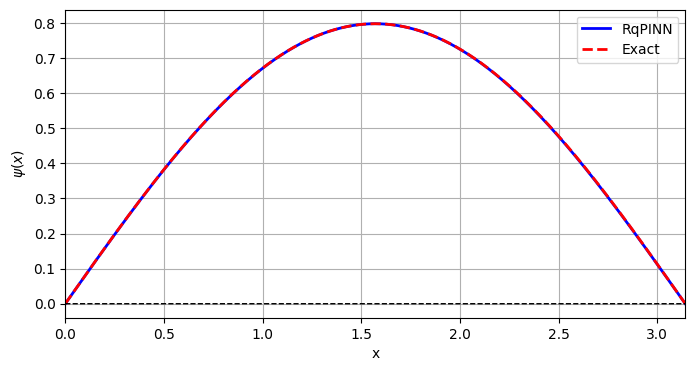

In [59]:
fig, ax1 = plt.subplots(figsize=(8,4))
#Ensure to adjust the sign accordingly when scaling!!
ax1.plot(t_net, -np.sqrt(2/np.pi)*psi[:,0]/max(abs(psi[:, 0])), color='blue', linewidth=2, label=f'RqPINN')
ax1.plot(t_net, y_exact[1],'--r', linewidth=2, label = 'Exact')
ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
ax1.set_xlim(0,np.pi)
ax1.tick_params(axis='y', color='black')
ax1.legend(loc='upper right')

plt.grid('on')
plt.show()

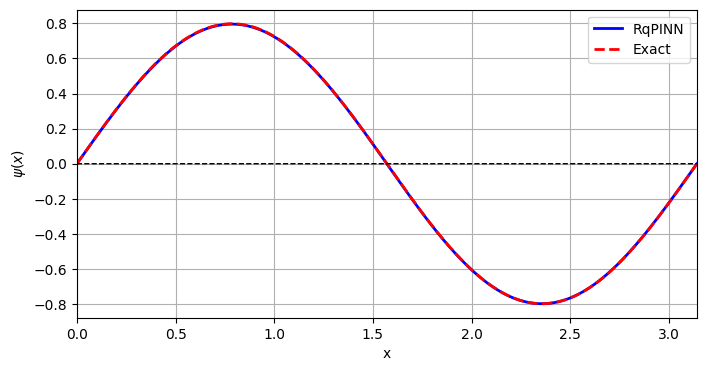

In [60]:
fig, ax1 = plt.subplots(figsize=(8,4))
#Ensure to adjust the sign accordingly when scaling!!
ax1.plot(t_net, -np.sqrt(2/np.pi)*psi[:,1]/max(abs(psi[:, 1])), color='blue', linewidth=2, label=f'RqPINN')
ax1.plot(t_net, y_exact[2],'--r', linewidth=2, label = 'Exact')
ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
ax1.set_xlim(0,np.pi)
ax1.tick_params(axis='y', color='black')
ax1.legend(loc='upper right')

plt.grid('on')
plt.show()

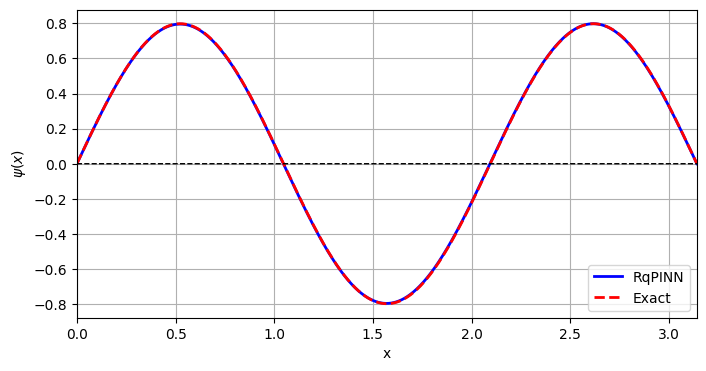

In [61]:
fig, ax1 = plt.subplots(figsize=(8,4))
#Ensure to adjust the sign accordingly when scaling!!
ax1.plot(t_net, np.sqrt(2/np.pi)*psi[:,2]/max(abs(psi[:, 2])), color='blue', linewidth=2, label=f'RqPINN')
ax1.plot(t_net, y_exact[3],'--r', linewidth=2, label = 'Exact')
ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
ax1.set_xlim(0,np.pi)
ax1.tick_params(axis='y', color='black')
ax1.legend(loc='lower right')

plt.grid('on')
plt.show()

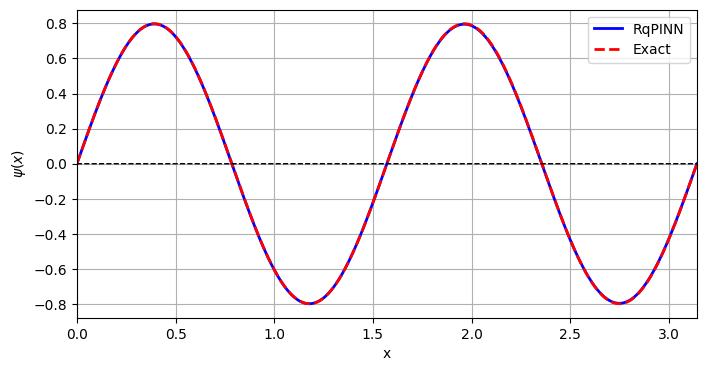

In [62]:
fig, ax1 = plt.subplots(figsize=(8,4))
#Ensure to adjust the sign accordingly when scaling!!
ax1.plot(t_net, np.sqrt(2/np.pi)*psi[:,3]/max(abs(psi[:, 3])), color='blue', linewidth=2, label=f'RqPINN')
ax1.plot(t_net, y_exact[4],'--r', linewidth=2, label = 'Exact')
ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
ax1.set_xlim(0,np.pi)
ax1.tick_params(axis='y', color='black')
ax1.legend(loc='upper right')

plt.grid('on')
plt.show()

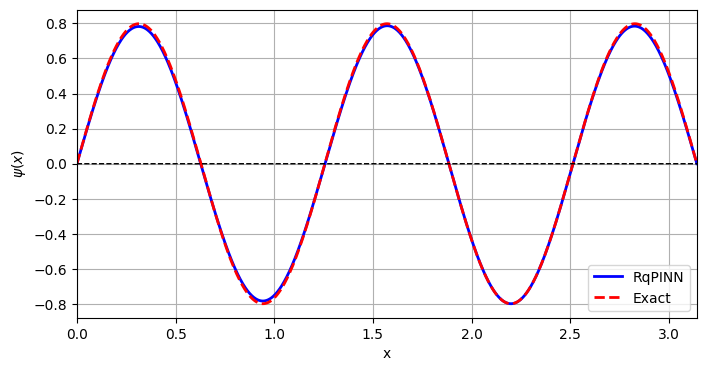

In [63]:
fig, ax1 = plt.subplots(figsize=(8,4))
#Ensure to adjust the sign accordingly when scaling!!
ax1.plot(t_net, -np.sqrt(2/np.pi)*psi[:,4]/max(abs(psi[:, 4])), color='blue', linewidth=2, label=f'RqPINN')
ax1.plot(t_net, y_exact[5],'--r', linewidth=2, label = 'Exact')
ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
ax1.set_xlim(0,np.pi)
ax1.tick_params(axis='y', color='black')
ax1.legend(loc='lower right')

plt.grid('on')
plt.show()

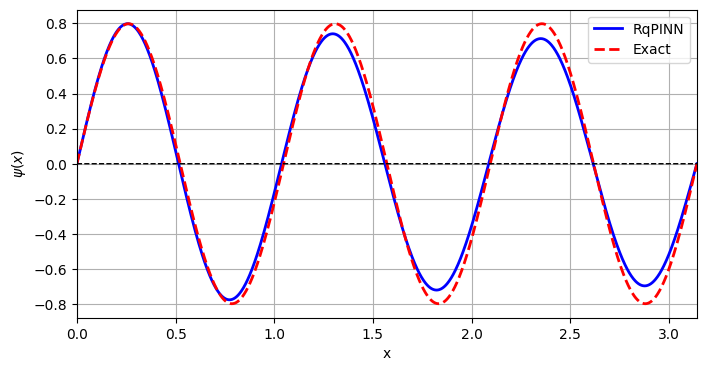

In [66]:
fig, ax1 = plt.subplots(figsize=(8,4))
#Ensure to adjust the sign accordingly when scaling!!
ax1.plot(t_net, np.sqrt(2/np.pi)*psi[:,5]/max(abs(psi[:, 5])), color='blue', linewidth=2, label=f'RqPINN')
ax1.plot(t_net, y_exact[6],'--r', linewidth=2, label = 'Exact')
ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
ax1.set_xlim(0,np.pi)
ax1.tick_params(axis='y', color='black')
ax1.legend(loc='upper right')

plt.grid('on')
plt.show()

## Projecting the Output into an orthonormal basis

In [70]:
#Adding a custom orthonormal projection layer
class qrlayer(torch.nn.Module):
    def forward(self, x):
        Q,_ = torch.linalg.qr(x)
        return Q

#Now adding the layer to the neural network architecture
class qNN_qr(torch.nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.base = qNN(layers)
        self.qr = qrlayer()

    def forward(self, x):
        out = self.base(x)
        out = self.qr(out/torch.norm(out, dim = 0, keepdim = True))
        return out

In [71]:
model1 = qNN_qr(layers)
model1.to(device)
print(model1)
#params = list(model.parameters())
betas = [0.999, 0.9999]
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas)

qNN_qr(
  (base): qNN(
    (activation): sine()
    (linears): ModuleList(
      (0): Linear(in_features=1, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=6, bias=True)
    )
  )
  (qr): qrlayer()
)


In [72]:
def nn_qr_train(NN,t0,tf,xbc,col_pts, epochs,t):
  En_history = [] #To store the eigenvalues as it is optimized
  loss_keys = ['pde_loss_hist']
  loss_dic = {key: [] for key in loss_keys} #To store the losses
  t_rand = t[torch.randperm(t.shape[0])].to(device).float() #Reshuffling the collocation points
  t_rand.requires_grad =True

  #Dictionary to store the final training
  dic = {}

  stime = time.time()
  for iter in range(epochs + 1):
    loss = 0.0

    #Getting the parametric solution
    psi =parametricSolutions(t_rand,NN,t0,tf,xbc).to(device) #The forward pass

    L,En = hamEqs_Loss(t_rand,psi)
    En_history.append(En.cpu().detach().numpy())
    Loss = torch.nn.MSELoss()
    criteria_loss = eig_num*Loss(L,torch.zeros_like(L)) #The scaled pde_loss
    #Getting the loss after the forward pass
    loss_dic['pde_loss_hist'].append(criteria_loss.cpu().detach().numpy().item())



    if iter % 200 == 0:
      print('--------------------------------------------')
      print(f'Epoch: {iter}')
      print(f'En: {En_history[-1]}')
      print('--------------------------------------------')
      print('Total_loss: ',criteria_loss.cpu().detach().numpy())


    #Backward propagation
    optimizer.zero_grad()
    criteria_loss.backward()
    #Introducing Gradient clipping
    #max_norm =12.0
    #torch.nn.utils.clip_grad_norm_(NN.parameters(), max_norm)
    optimizer.step()
    loss += criteria_loss.cpu().detach().numpy()

  #Storing the final eigenfunction and eigenvalue
  dic[1] = copy.deepcopy(NN)


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return loss_dic, np.array(En_history), dic

In [ ]:
Loss, eig_vals, qPINN = nn_qr_train(model1,t0,tf,xbc,col_pts,epochs, x_lhs) 